File to train on the toy_df.csv (that came from the 001_Forbes Dataset)

In [28]:
import os
import ast
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
import random
import pandas as pd
from transformers import TapasConfig, TapasForQuestionAnswering, TapasTokenizer, AdamW, get_linear_schedule_with_warmup
warnings.filterwarnings("ignore")

In [15]:
# load in tokenizer
tokenizer = TapasTokenizer.from_pretrained("google/tapas-base-finetuned-wtq")
base_tokenizer = TapasTokenizer.from_pretrained("google/tapas-base")

In [16]:
# Function to convert the string representation to a list of tuples
def parse_answer_coords(coords_str):
    try:
        # Safely evaluate the string to a Python object
        coords = ast.literal_eval(coords_str)
        
        # Ensure the result is a list of tuples with integers
        if isinstance(coords, list) and all(
            isinstance(coord, (tuple, list)) and len(coord) == 2 and all(isinstance(x, int) for x in coord)
            for coord in coords
        ):
            return [tuple(coord) for coord in coords]  # Convert lists to tuples if needed
        else:
            raise ValueError(f"Invalid format for answer_coords: {coords_str}")
    except (ValueError, SyntaxError) as e:
        raise ValueError(f"Error parsing answer_coords: {coords_str}. Details: {e}")

In [17]:
# class to tokenizer dataset
class TableDataset(torch.utils.data.Dataset):
    def __init__(self, data, tokenizer):
        self.data = self.process_answer_coords_column(data)
        self.tokenizer = tokenizer
        self.table_csv_path = 'data/'

    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        table = pd.read_csv(self.table_csv_path + item.dataset).astype(
            str
        )  # be sure to make your table data text only

        encoding = self.tokenizer(
            table=table,
            queries=item.question,
            answer_coordinates=item.answer_coords,
            answer_text=item.sample_answer,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )
        # remove the batch dimension which the tokenizer adds by default
        encoding = {key: val.squeeze(0) for key, val in encoding.items()}
        # add the float_answer which is also required (weak supervision for aggregation case)
        encoding["float_answer"] = torch.tensor(item.float_answer)
        return encoding

    def __len__(self):
        return len(self.data)
    
    # change answer_coords from strings
    def process_answer_coords_column(self, data, column_name="answer_coords"):
        if column_name not in data.columns:
            raise ValueError(f"Column '{column_name}' does not exist in the dataset.")

        def parse_answer_coords(coords_str):
            try:
                coords = ast.literal_eval(coords_str)
                if isinstance(coords, list) and all(
                    isinstance(coord, (tuple, list)) and len(coord) == 2 and all(isinstance(x, int) for x in coord)
                    for coord in coords
                ):
                    return [tuple(coord) for coord in coords]
                else:
                    raise ValueError(f"Invalid format for answer_coords: {coords_str}")
            except (ValueError, SyntaxError) as e:
                raise ValueError(f"Error parsing answer_coords: {coords_str}. Details: {e}")
        data[column_name] = data[column_name].apply(parse_answer_coords)
        return data

In [61]:
# load in toy_df, tokenize and place in dataloader
csv_path = 'data/toy_df.csv'
df = pd.read_csv(csv_path)

csv_path_v2 =  'data/toy_df_v2.csv'
df_v2 = pd.read_csv(csv_path_v2)

datasets = list(set(df['dataset']))
train_datasets = datasets[:len(datasets) - 2]
dev_datasets = datasets[len(datasets) - 2:]

train_df = df[df['dataset'].isin(train_datasets)]
train_df_v2 = df_v2[df_v2['dataset'].isin(train_datasets)]
dev_df = df[df['dataset'].isin(dev_datasets)]


# load train dataloader
train_dataset = TableDataset(train_df, tokenizer)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8)

# load train_v2 dataloader
train_dataset_v2 = TableDataset(train_df_v2, tokenizer)
train_dataloader_v2 = torch.utils.data.DataLoader(train_dataset_v2, batch_size=8)

# load dev dataloader
dev_dataset = TableDataset(dev_df, tokenizer)
dev_dataloader = torch.utils.data.DataLoader(dev_dataset, batch_size=8)

# get test datasets
test_data = pd.read_csv('data/test.csv')
test_dfs = list(set(test_data['dataset']))

In [29]:
# load in WTQ model (from TAPAS documentation)
config = TapasConfig(
    num_aggregation_labels=4,
    use_answer_as_supervision=True,
    answer_loss_cutoff=0.664694,
    cell_selection_preference=0.207951,
    huber_loss_delta=0.121194,
    init_cell_selection_weights_to_zero=True,
    select_one_column=True,
    allow_empty_column_selection=False,
    temperature=0.0352513,
)

model_wtq = TapasForQuestionAnswering.from_pretrained("google/tapas-base-finetuned-wtq", config=config) # leave as is
model_finetune = TapasForQuestionAnswering.from_pretrained("google/tapas-base-finetuned-wtq", config=config) # finetune
optimizer = AdamW(model_finetune.parameters(), lr=1e-5) # trying to change leaening rate

In [30]:
def train_model(
    model, 
    train_dataloader, 
    dev_dataloader, 
    optimizer, 
    device, 
    epochs, 
    save_path, 
    description="Training Parameters Description"
):
    
    # Calculate total training steps
    total_steps = len(train_dataloader) * epochs
    
    # Create scheduler
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,  # Optional warm-up period
        num_training_steps=total_steps
    )
    
    best_dev_loss = float('inf')
    model.to(device)
    
    save_path = 'models/' + save_path
    train_losses = [] 
    dev_losses = []    
    
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        model.train()
        epoch_train_loss = 0

        # Training loop
        for batch in tqdm(train_dataloader, desc="Training"):
            optimizer.zero_grad()
            inputs = {key: value.to(device) for key, value in batch.items()}
            outputs = model(**inputs)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            scheduler.step()
            epoch_train_loss += loss.item()
        epoch_train_loss /= len(train_dataloader)
        train_losses.append(epoch_train_loss)
        
        
        # Evaluate on dev set
        epoch_dev_loss = 0
        model.eval()
        with torch.no_grad():
            for batch in tqdm(dev_dataloader, desc="Validation"):
                inputs = {key: value.to(device) for key, value in batch.items()}
                outputs = model(**inputs)
                loss = outputs.loss
                epoch_dev_loss += loss.item()
        epoch_dev_loss /= len(dev_dataloader)
        dev_losses.append(epoch_dev_loss)
        
        print(f"Training loss for epoch {epoch + 1}: {epoch_train_loss:.4f}")
        print(f"Validation loss for epoch {epoch + 1}: {epoch_dev_loss:.4f}")
        
    
    # Save final model
    model.save_pretrained(save_path)
    print(f"fine-tuned model saved to {save_path}")
    
    # Plot losses ans save
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), train_losses, label="Train Loss")
    plt.plot(range(1, epochs + 1), dev_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    # Save plot with description
    plt.savefig(f"{save_path}/training_loss_plot.png")
    print(f"Loss plot saved")
    
    # Save training description
    with open(f"{save_path}/training_description.txt", "w") as desc_file:
        desc_file.write(description)
        desc_file.write(f"\nEpochs: {epochs}")
        desc_file.write(f"\nFinal Train Loss: {train_losses[-1]:.4f}")
        desc_file.write(f"\nFinal Validation Loss: {dev_losses[-1]:.4f}")
    
    print('Done Training')
    return model

Epoch 1/5


Validation: 100%|█████████████████████████████████| 2/2 [00:08<00:00,  4.20s/it]


Training loss for epoch 1: 4.3714
Validation loss for epoch 1: 0.4362
Epoch 2/5


Validation: 100%|█████████████████████████████████| 2/2 [00:08<00:00,  4.16s/it]


Training loss for epoch 2: 1.8439
Validation loss for epoch 2: 0.2867
Epoch 3/5


Validation: 100%|█████████████████████████████████| 2/2 [00:08<00:00,  4.07s/it]


Training loss for epoch 3: 1.1767
Validation loss for epoch 3: 0.2393
Epoch 4/5


Validation: 100%|█████████████████████████████████| 2/2 [00:09<00:00,  4.68s/it]


Training loss for epoch 4: 0.9002
Validation loss for epoch 4: 0.2197
Epoch 5/5


Validation: 100%|█████████████████████████████████| 2/2 [00:09<00:00,  4.78s/it]
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'temperature': 0.0352513}


Training loss for epoch 5: 0.8355
Validation loss for epoch 5: 0.2134
fine-tuned model saved to models/wtq_finetune_five_epoch_lower_learn_schedule
Loss plot saved
Done Training


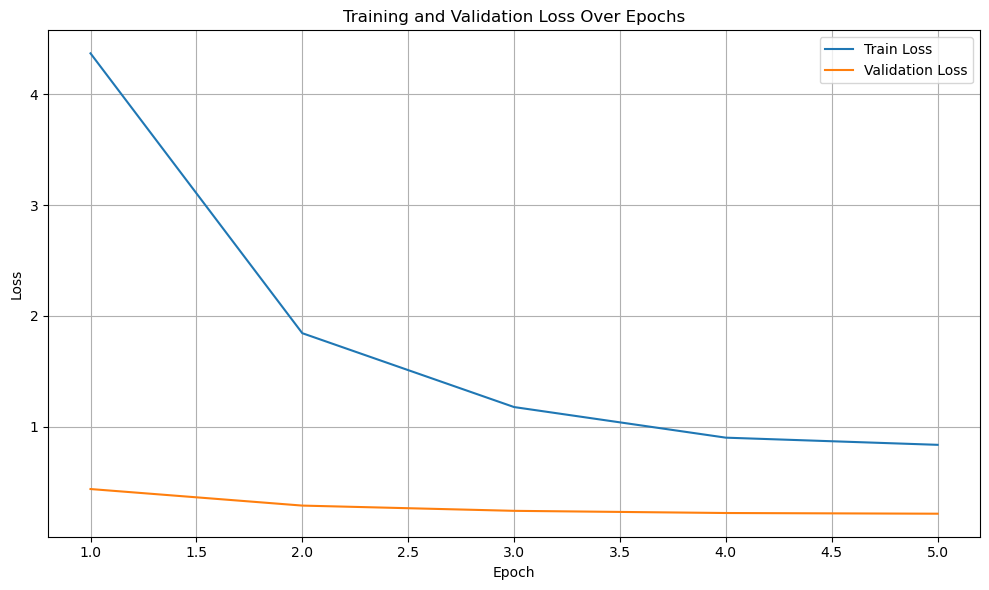

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
description = 'using toy_df.csv, changed learning rate to 1e-5, added a scheduler, only 5 epochs'

# Fine-tune model
model_finetune = train_model(
    model=model_finetune,
    train_dataloader=train_dataloader,
    dev_dataloader=dev_dataloader,
    optimizer=optimizer,
    device=device,
    epochs=5,
    save_path="wtq_finetune_five_epoch_lower_learn_schedule",
    description = description
)

In [76]:
# Inference
def inference(test_data, test_dfs, model):
    num_none = 0
    num_agg = 0
    num_correct = 0
    num_correct_none = 0
    num_correct_agg = 0
    total_questions = 0
    num_number = 0
    num_number_correct = 0
    num_category = 0
    num_category_correct = 0
    
    model.eval()
    
    with torch.no_grad():
        for file in test_dfs:
            print('#################### test on:', file,'####################')
            table = pd.read_csv(f'data/{file}').astype(str)
            df = test_data[test_data['dataset'] == file]
            queries = list(df['question'])
            inputs = tokenizer(
                table = table,
                queries = queries,
                padding="max_length",
                return_tensors="pt",
                truncation = True
            )

            outputs = model(**inputs)
            predicted_answer_coordinates, predicted_aggregation_indices = tokenizer.convert_logits_to_predictions(
                inputs, outputs.logits.detach(), outputs.logits_aggregation.detach()
            )

            # print results:
            id2aggregation = {0: "NONE", 1: "SUM", 2: "AVERAGE", 3: "COUNT"}
            aggregation_predictions_string = [id2aggregation[x] for x in predicted_aggregation_indices]

            answers = []
            for coordinates in predicted_answer_coordinates:
                if len(coordinates) == 1:
                    # only a single cell:
                    answers.append(table.iat[coordinates[0]])
                else:
                    # multiple cells
                    cell_values = []
                    for coordinate in coordinates:
                        cell_values.append(table.iat[coordinate])
                    answers.append(", ".join(cell_values))

            i = 0
            real_answers = list(df['sample_answer'])
            answer_type = list(df['type'])
            for query, answer, predicted_agg in zip(queries, answers, aggregation_predictions_string):
                total_questions += 1 
                #print(query)

               # print('Indeded type: ', answer_type[i])
                if answer_type[i] == 'number':
                    num_number += 1
                else:
                    num_category += 1

                if predicted_agg == "NONE":
                    #print("     Predicted answer: " + answer)
                    #print("     Real answer: ", real_answers[i])
                    if str(answer) == str(real_answers[i]):
                        #print('          CORRECT!')
                        num_correct += 1
                        num_correct_none += 1
                        if answer_type[i] == 'number':
                            num_number_correct += 1
                        else:
                            num_category_correct += 1

                    i += 1
                    num_none += 1

                else:
                    #print("     Predicted Cells: " + predicted_agg + " > " + answer)
                    if predicted_agg == 'COUNT':
                        count = answer.split(',')
                        answer = len(list(set(count)))
                        #print('     Predicted Count: ', answer)
                        if answer % 1 == 0:
                            answer = int(answer)

                    if predicted_agg == 'AVERAGE':
                        total = 0
                        a = answer.split(',')
                        try:
                            a = [float(elem) for elem in a]
                        except:
                            #print('     Predicted Average: Error')
                            answer = None
                            i += 1
                            #print("     Real answer: ", str(real_answers[i]))
                            num_agg += 1
                            continue
                        num = len(a)
                        answer = 0
                        for elem in a:
                            answer += (elem/num)  
                        #print('     Predicted Average:', answer)
                        if answer % 1 == 0:
                            answer = int(answer)
                            
                    if predicted_agg == 'SUM':
                        s = answer.split(',')
                        s = [float(elem) for elem in s]
                        answer = 0
                        for elem in s:
                            answer += elem
                        #print('     Predicted Sum:', answer)
                        if answer % 1 == 0:
                            answer = int(answer)

                    #print("     Real answer: ", str(real_answers[i]))
                    if str(answer) == str(real_answers[i]):
                            #print('          CORRECT!')
                            num_correct += 1
                            num_correct_agg += 1
                            if answer_type[i] == 'number':
                                num_number_correct += 1
                            else:
                                num_category_correct += 1
                            
                    i += 1
                    num_agg += 1

        print("")
        print('Number of Questions: ', total_questions)
        print('Overall Accuracy: ', num_correct/total_questions)
        print('Number Accuracy: ', num_number_correct/num_number)
        print('Category Accuracy: ', num_category_correct/num_category)
        try:
            print('NONE Accuracy:', num_correct_none/num_none)
        except:
            print('***** No questions with predicted Aggregation Tag NONE ***** ')
        try:
            print('Agg Accuracy:', num_correct_agg/num_agg)
        except:
            print('***** No questions with predicted Aggregation Tag SUM, AVERAGE, or COUNT ***** ')
        print("")

In [69]:
model_loaded = TapasForQuestionAnswering.from_pretrained("models/wtq_finetune_a")
tok_test = TapasTokenizer.from_pretrained("google/tapas-base-finetuned-wtq")

In [70]:
# inference on finetuned model - test data
inference(test_data, test_dfs, model_loaded)

#################### test on: 037_Ted.csv ####################
          CORRECT!
#################### test on: 038_Stroke.csv ####################
#################### test on: 036_US.csv ####################


KeyboardInterrupt: 

In [ ]:
# inference on wtq model - test data
inference(test_data, test_dfs, model_wtq)

In [ ]:
# test to see if finetuning was effective (for bugs) on train set
# inference on finetuned model - train data
inference(train_df, train_datasets, model_loaded)

# inference on wtq model - train data
#inference(train_df, train_datasets, model_wtq)

Report accuracy train and dev (x-axis epoch, and y-axis loss) -> jsut show that I am thinking about overfitting
Run error analysis on answer length by accuracy 
fix and and train data split
talk about if I had more time... this is what I would have done

Observations 
- the aggregation operator is often wrong, but still gets the right answer
    - for example when looking for a max value, chooses the AVERAGE operator, but only on one cell so still correct
- my finetuned model (on toy_df_vw) did not work I do not know why
    - gets almost nothing right 
    - when I test on my train set
    - I think that adding the extra coordinates is screwing with the model
            - Number of Questions:  89
            - Overall Accuracy:  0.10112359550561797
            - Number Accuracy:  0.022727272727272728
            - Category Accuracy:  0.08888888888888889
            - NONE Accuracy: 0.09259259259259259
            - Agg Accuracy: 0.12903225806451613
            
    - the non-fintuned wtq version was this:
            - Number of Questions:  89
            - Overall Accuracy:  0.23595505617977527
            - Number Accuracy:  0.022727272727272728
            - Category Accuracy:  0.24444444444444444
            - NONE Accuracy: 0.2727272727272727
            - Agg Accuracy: 0.20454545454545456

Things to do 
- try to train on the df_v2 for 5 epochs
- try to train on both versions of train data with altered questions
- train for 6 or 7 epochs?

In [71]:
tokenizer = TapasTokenizer.from_pretrained("google/tapas-base-finetuned-wtq")

In [72]:
# Evaluation wtq
wtq = TapasForQuestionAnswering.from_pretrained("google/tapas-base-finetuned-wtq")
inference(train_df, train_datasets, wtq) # toy_df
inference(train_df_v2, train_datasets, wtq) # toy_df_v2
inference(test_data, test_dfs, wtq) # test

#################### test on: 005_NYC.csv ####################
#################### test on: 007_Fifa.csv ####################
          CORRECT!
          CORRECT!
          CORRECT!
#################### test on: 019_Aircraft.csv ####################
          CORRECT!
#################### test on: 002_Titanic.csv ####################
#################### test on: 001_Forbes.csv ####################
#################### test on: 004_Taxi.csv ####################
          CORRECT!
#################### test on: 013_Roller.csv ####################
#################### test on: 008_Tornados.csv ####################
#################### test on: 017_Hacker.csv ####################
          CORRECT!
          CORRECT!
#################### test on: 010_ECommerce.csv ####################
          CORRECT!
          CORRECT!
#################### test on: 012_Heart.csv ####################
          CORRECT!
#################### test on: 018_Staff.csv ####################
###################

In [73]:
# Evaluation wtq_finetune
wtq_finetune = TapasForQuestionAnswering.from_pretrained("models/wtq_finetune")
inference(train_df, train_datasets, wtq_finetune) # toy_df
inference(train_df_v2, train_datasets, wtq_finetune) # toy_df_v2
inference(test_data, test_dfs, wtq_finetune) # test

#################### test on: 005_NYC.csv ####################
#################### test on: 007_Fifa.csv ####################
          CORRECT!
#################### test on: 019_Aircraft.csv ####################
#################### test on: 002_Titanic.csv ####################
#################### test on: 001_Forbes.csv ####################
#################### test on: 004_Taxi.csv ####################
#################### test on: 013_Roller.csv ####################
#################### test on: 008_Tornados.csv ####################
          CORRECT!
#################### test on: 017_Hacker.csv ####################
          CORRECT!
#################### test on: 010_ECommerce.csv ####################
#################### test on: 012_Heart.csv ####################
#################### test on: 018_Staff.csv ####################
#################### test on: 015_Food.csv ####################
#################### test on: 011_SF.csv ####################
          CORRECT!

Number

In [74]:
# Evaluation wtq_finetune_a
wtq_finetune_a = TapasForQuestionAnswering.from_pretrained("models/wtq_finetune_a")
inference(train_df, train_datasets, wtq_finetune_a) # toy_df
inference(train_df_v2, train_datasets, wtq_finetune_a) # toy_df_v2
inference(test_data, test_dfs, wtq_finetune_a) # test

#################### test on: 005_NYC.csv ####################
          CORRECT!
#################### test on: 007_Fifa.csv ####################
          CORRECT!
          CORRECT!
#################### test on: 019_Aircraft.csv ####################
          CORRECT!
#################### test on: 002_Titanic.csv ####################
#################### test on: 001_Forbes.csv ####################
#################### test on: 004_Taxi.csv ####################
#################### test on: 013_Roller.csv ####################
#################### test on: 008_Tornados.csv ####################
#################### test on: 017_Hacker.csv ####################
          CORRECT!
          CORRECT!
#################### test on: 010_ECommerce.csv ####################
          CORRECT!
#################### test on: 012_Heart.csv ####################
#################### test on: 018_Staff.csv ####################
#################### test on: 015_Food.csv ####################
############

In [75]:
# Evaluation wtq_finetune_five_epoch_lower_learn schedule
wtq_finetune_five = TapasForQuestionAnswering.from_pretrained("models/wtq_finetune_five_epoch_lower_learn_schedule")
inference(train_df, train_datasets, wtq_finetune_five) # toy_df
inference(train_df_v2, train_datasets, wtq_finetune_five) # toy_df_v2
inference(test_data, test_dfs, wtq_finetune_five) # test

#################### test on: 005_NYC.csv ####################
#################### test on: 007_Fifa.csv ####################
          CORRECT!
          CORRECT!
#################### test on: 019_Aircraft.csv ####################
          CORRECT!
#################### test on: 002_Titanic.csv ####################
#################### test on: 001_Forbes.csv ####################
#################### test on: 004_Taxi.csv ####################
          CORRECT!
#################### test on: 013_Roller.csv ####################
#################### test on: 008_Tornados.csv ####################
#################### test on: 017_Hacker.csv ####################
          CORRECT!
          CORRECT!
#################### test on: 010_ECommerce.csv ####################
          CORRECT!
          CORRECT!
#################### test on: 012_Heart.csv ####################
          CORRECT!
          CORRECT!
#################### test on: 018_Staff.csv ####################
###################